# AI Project: Neural Network



---

In [36]:
# Libraries
import matplotlib
import numpy as np
import pandas as pd
from ucimlrepo import fetch_ucirepo
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Modules
from ai_nn_project.utils.activations import Sigmoid, ReLU, Linear
from ai_nn_project.utils.visualisation import visualize_weights
from ai_nn_project.utils.evaluations import accuracy, precision, recall, f1_score, mse_loss
from ai_nn_project.models.neuronal_network.multilayer_perceptron import MLP

# make figures appear inline
matplotlib.rcParams['figure.figsize'] = (15, 8)
%matplotlib inline

# notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


---

## Introduction

## Data

### Mushroom Dataset: Classification

In [37]:
# fetch dataset

# Mushroom. (1987). UCI Machine Learning Repository. https://doi.org/10.24432/C5959T.
mushroom = fetch_ucirepo(id=73) 

# Cortez,Paulo, Cerdeira,A., Almeida,F., Matos,T., and Reis,J.. (2009). Wine Quality. UCI Machine Learning Repository. https://doi.org/10.24432/C56S3T.
wine_quality = fetch_ucirepo(id=186)

In [38]:
mushroom_X = mushroom.data.features
mushroom_y = mushroom.data.targets

In [39]:
mushroom_X.head()

,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,x,s,n,t,p,f,c,n,k,e,...,s,w,w,p,w,o,p,k,s,u
1,x,s,y,t,a,f,c,b,k,e,...,s,w,w,p,w,o,p,n,n,g
2,b,s,w,t,l,f,c,b,n,e,...,s,w,w,p,w,o,p,n,n,m
3,x,y,w,t,p,f,c,n,n,e,...,s,w,w,p,w,o,p,k,s,u
4,x,s,g,f,n,f,w,b,k,t,...,s,w,w,p,w,o,e,n,a,g


In [40]:
mushroom_y.head()

,poisonous
0,p
1,e
2,e
3,p
4,e


In [41]:
# Encode categorical features as a one-hot numeric array: Gives a unique number to each category
le = LabelEncoder()

mushroom_X_encoded = mushroom_X.apply(le.fit_transform).to_numpy()
mushroom_y_encoded = mushroom_y.apply(le.fit_transform).to_numpy()

mushroom_X_train, mushroom_X_test, mushroom_y_train, mushroom_y_test = train_test_split(mushroom_X_encoded, mushroom_y_encoded, test_size=0.2, random_state=42)

### Wine Dataset: Regression

In [42]:
wine_X = wine_quality.data.features
wine_y = wine_quality.data.targets

In [43]:
wine_X.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4


In [44]:
wine_y.head()

,quality
0,5
1,5
2,5
3,6
4,5


In [25]:
scaler = StandardScaler()
wine_X_scaled = scaler.fit_transform(wine_X)
wine_y_scaled = wine_y.to_numpy()

wine_X_train, wine_X_test, wine_y_train, wine_y_test = train_test_split(wine_X_scaled, wine_y_scaled, test_size=0.2, random_state=42)

## Multi-Layer Perceptron: Classification

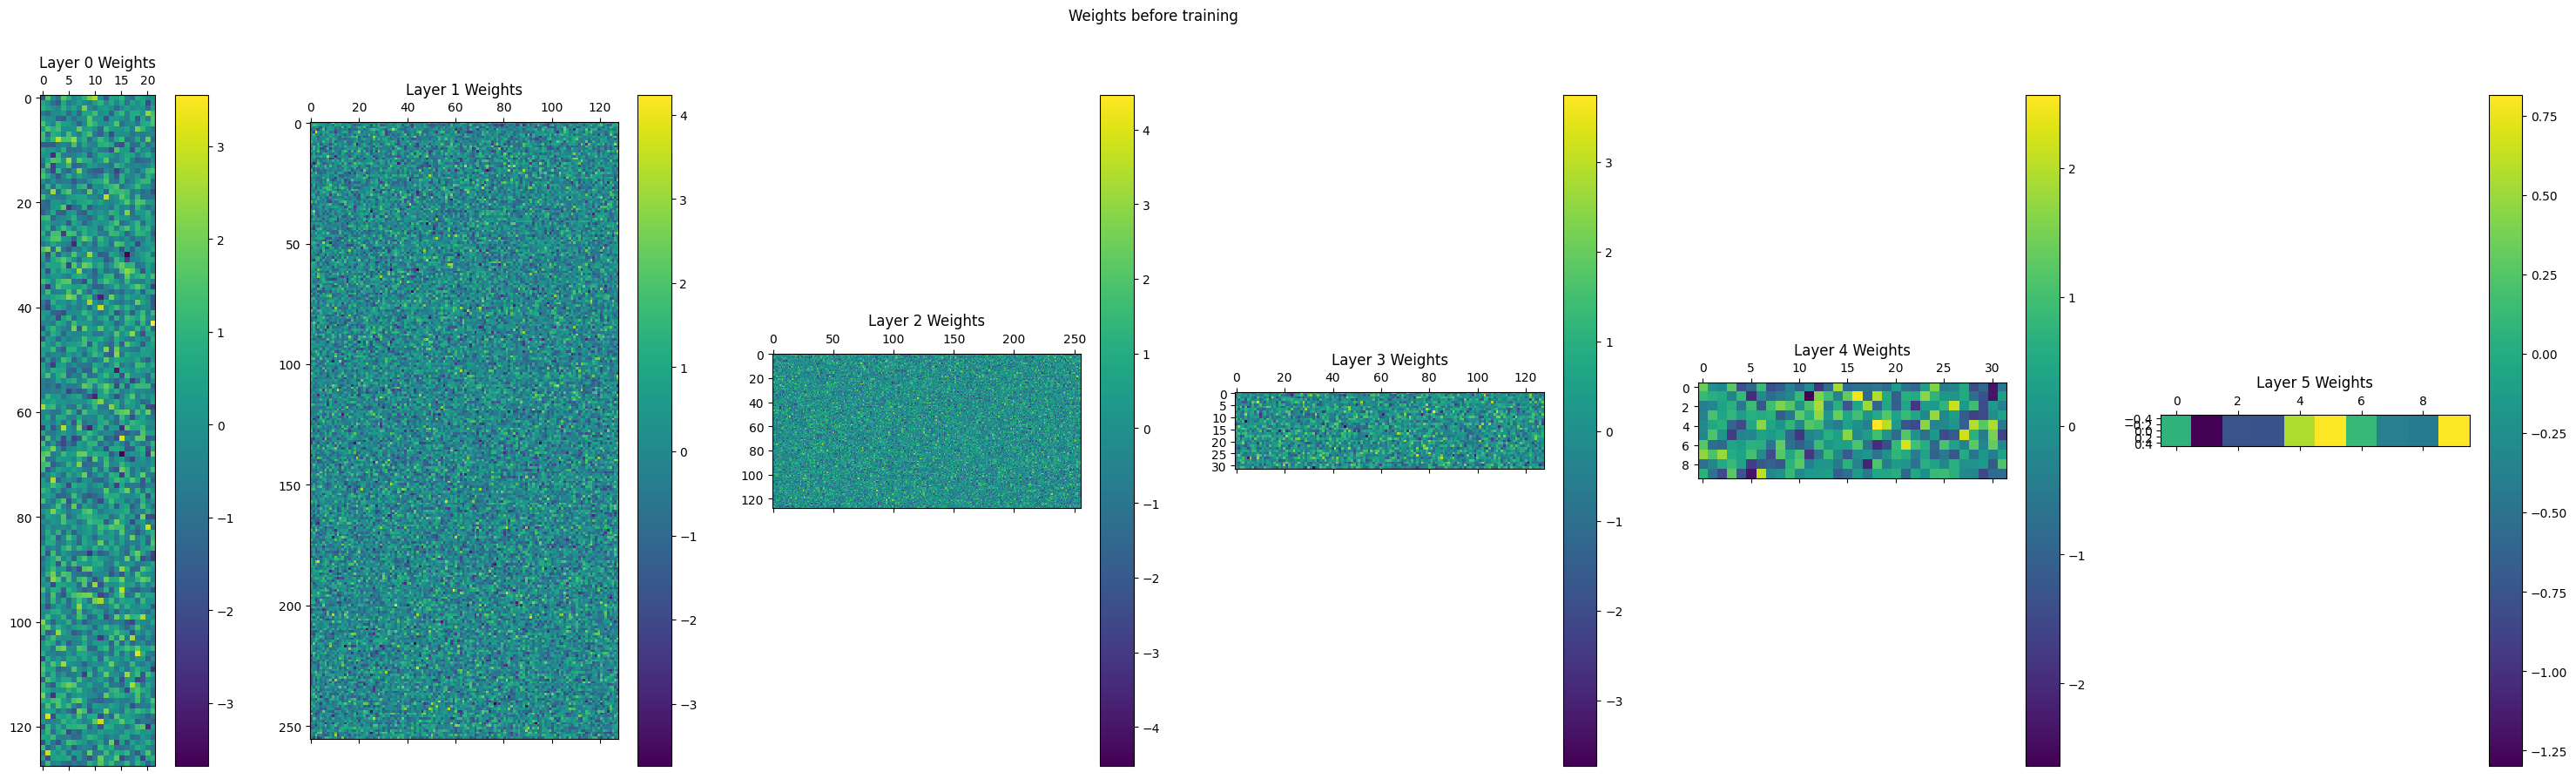

Training Progress:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 1/64 - {'mse_loss': 71445.9048159602}
Epoch 2/64 - {'mse_loss': 0.4820769636267791}
Epoch 3/64 - {'mse_loss': 0.48240643120716925}
Epoch 4/64 - {'mse_loss': 0.4821867861535758}
Epoch 5/64 - {'mse_loss': 0.4821867861535758}
Epoch 6/64 - {'mse_loss': 0.48240643120716925}
Epoch 7/64 - {'mse_loss': 0.4820769636267792}
Epoch 8/64 - {'mse_loss': 0.4821867861535758}
Epoch 9/64 - {'mse_loss': 0.48229660868037255}
Epoch 10/64 - {'mse_loss': 0.48240643120716914}
Epoch 11/64 - {'mse_loss': 0.4820769636267792}
Epoch 12/64 - {'mse_loss': 0.48240643120716914}
Epoch 13/64 - {'mse_loss': 0.4820769636267791}
Epoch 14/64 - {'mse_loss': 0.4821867861535758}
Epoch 15/64 - {'mse_loss': 0.48229660868037255}
Epoch 16/64 - {'mse_loss': 0.4821867861535758}
Epoch 17/64 - {'mse_loss': 0.4820769636267792}
Epoch 18/64 - {'mse_loss': 0.48229660868037255}
Epoch 19/64 - {'mse_loss': 0.48229660868037255}
Epoch 20/64 - {'mse_loss': 0.48196714109998245}
Epoch 21/64 - {'mse_loss': 0.4820769636267792}
Epoch 22/64 - {

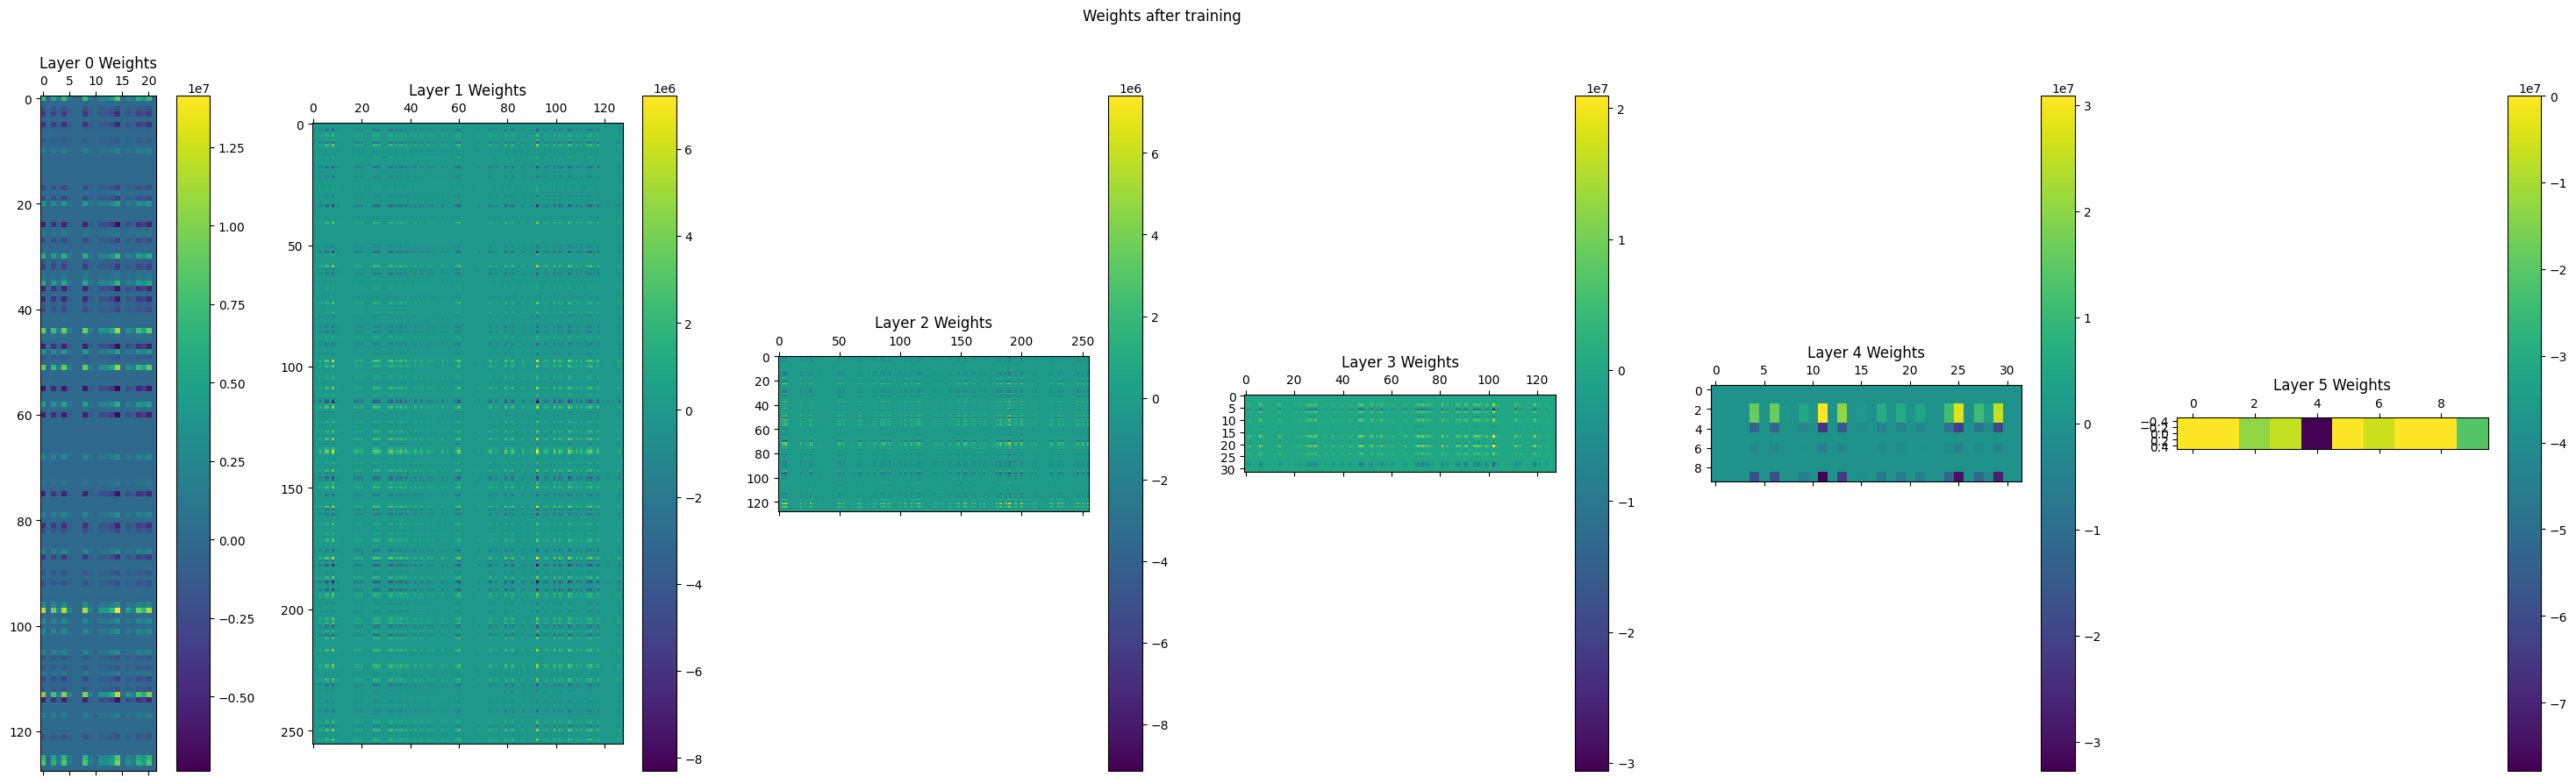

In [45]:
layer_sizes = [mushroom_X_train.shape[1], 128, 256, 128, 32, 10, 1]
activations = [ReLU(), ReLU(), ReLU(), ReLU(), ReLU(), ReLU(), Sigmoid()]

mushroom_netword = MLP(layer_sizes, activations, learning_rate=0.1)

visualize_weights(mushroom_netword, title="Weights before training")

metrics = mushroom_netword.train(mushroom_X_train, mushroom_y_train, epochs=64, batch_size=12, verbose=True)

visualize_weights(mushroom_netword, title="Weights after training")

In [46]:
mushroom_output = mushroom_netword.predict(mushroom_X_test.T) 

# convert to binary
mushroom_output = np.where(mushroom_output > 0.5, 1, 0)

print("Accuracy: ", accuracy(mushroom_y_test, mushroom_output))
print("Precision: ", precision(mushroom_y_test, mushroom_output))
print("Recall: ", recall(mushroom_y_test, mushroom_output))
print("F1-Score: ", f1_score(mushroom_y_test, mushroom_output))

Accuracy:  0.5187692307692308
Precision:  0
Recall:  0.0
F1-Score:  0


## Multi-Layer Perceptron: Reggression

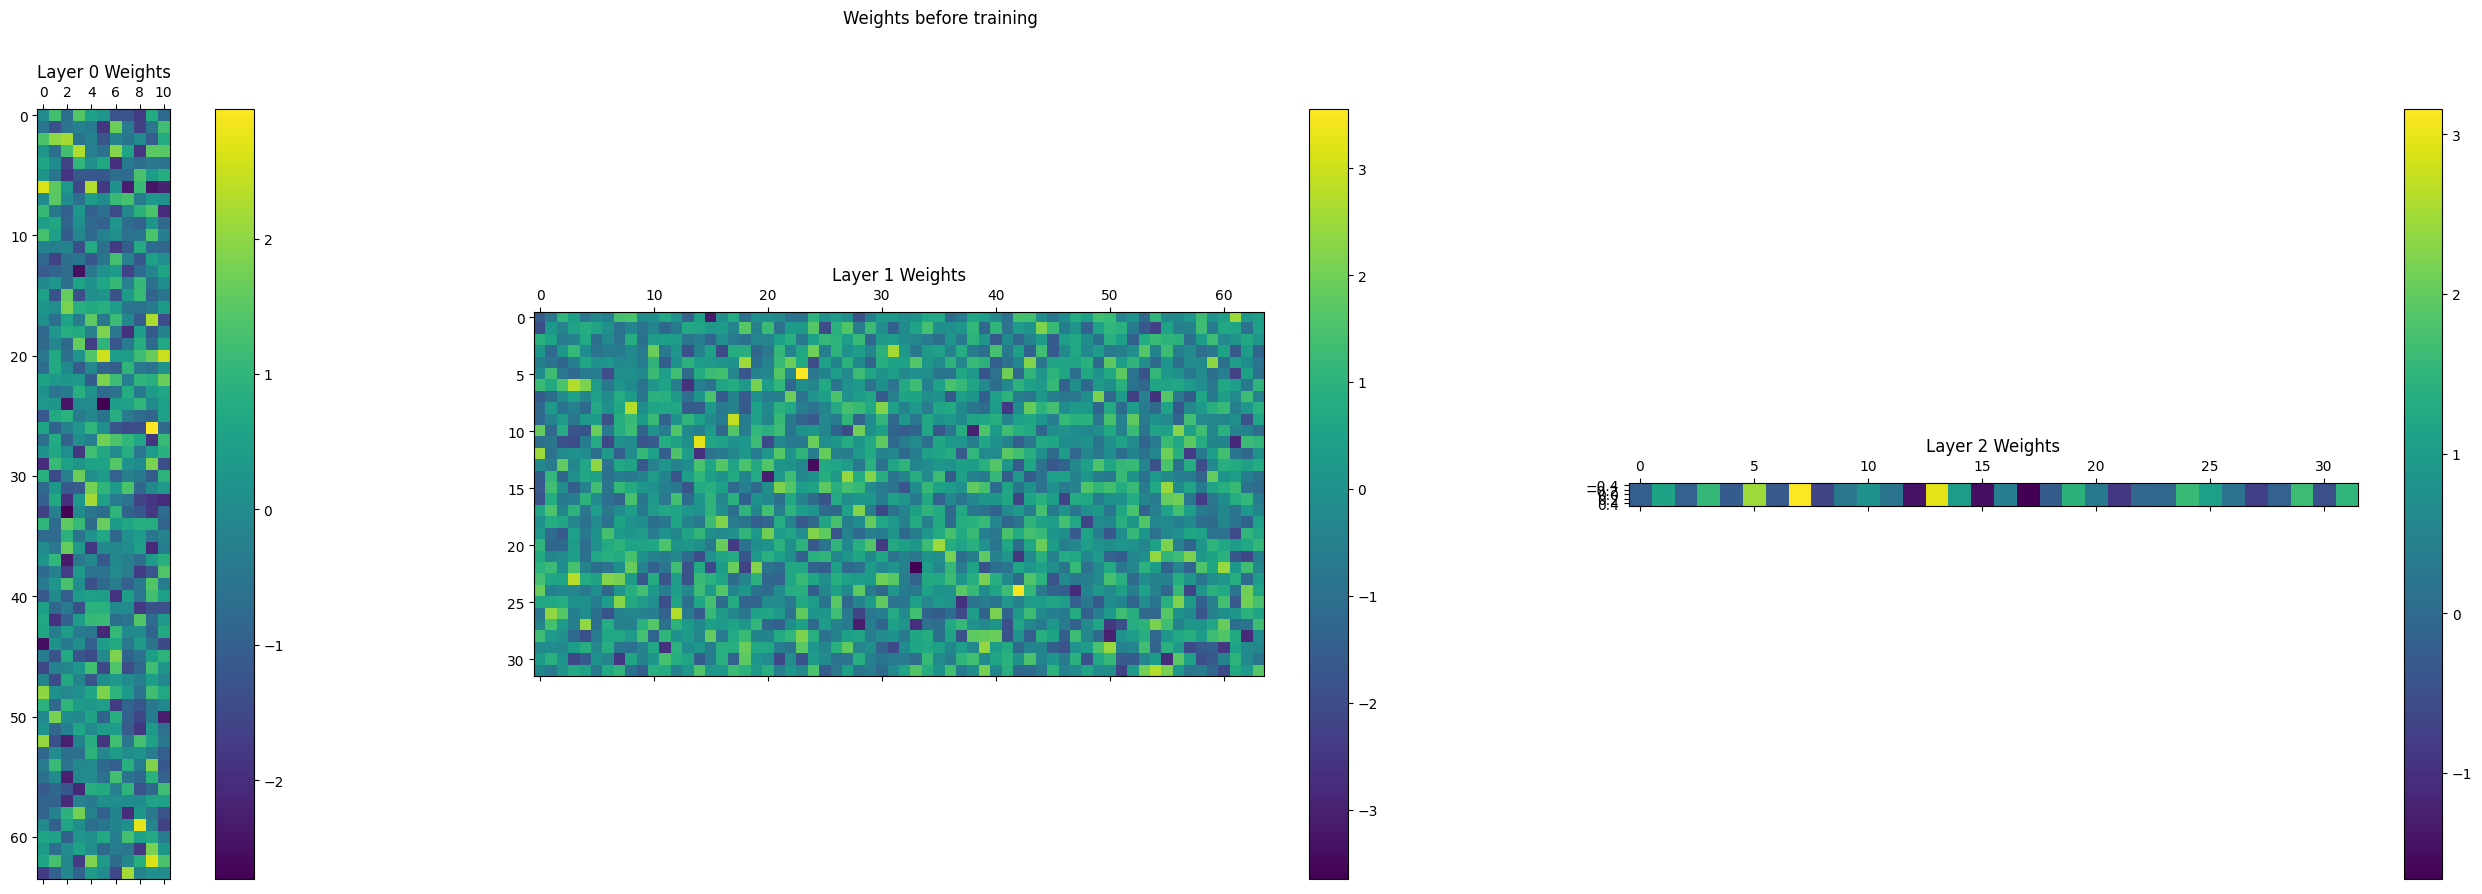

Training Progress:   0%|          | 0/128 [00:00<?, ?it/s]

Epoch 1/128 - {'mse_loss': 1.3262452395817688e+22}
Epoch 2/128 - {'mse_loss': 1036222.4386599542}
Epoch 3/128 - {'mse_loss': 0.7698476267836276}
Epoch 4/128 - {'mse_loss': 0.7685814757917543}
Epoch 5/128 - {'mse_loss': 0.7701870156804664}
Epoch 6/128 - {'mse_loss': 0.7719508169797115}
Epoch 7/128 - {'mse_loss': 0.7707204861151006}
Epoch 8/128 - {'mse_loss': 0.7709026663950753}
Epoch 9/128 - {'mse_loss': 0.7723446509075714}
Epoch 10/128 - {'mse_loss': 0.7707541332390642}
Epoch 11/128 - {'mse_loss': 0.7690447015574075}
Epoch 12/128 - {'mse_loss': 0.7688048843724286}
Epoch 13/128 - {'mse_loss': 0.7699015444597463}
Epoch 14/128 - {'mse_loss': 0.7725561175369732}
Epoch 15/128 - {'mse_loss': 0.7691944830224285}
Epoch 16/128 - {'mse_loss': 0.7721253937075198}
Epoch 17/128 - {'mse_loss': 0.7701817826904773}
Epoch 18/128 - {'mse_loss': 0.7689260837834717}
Epoch 19/128 - {'mse_loss': 0.769514432066863}
Epoch 20/128 - {'mse_loss': 0.7684675471214324}
Epoch 21/128 - {'mse_loss': 0.7714210954967254

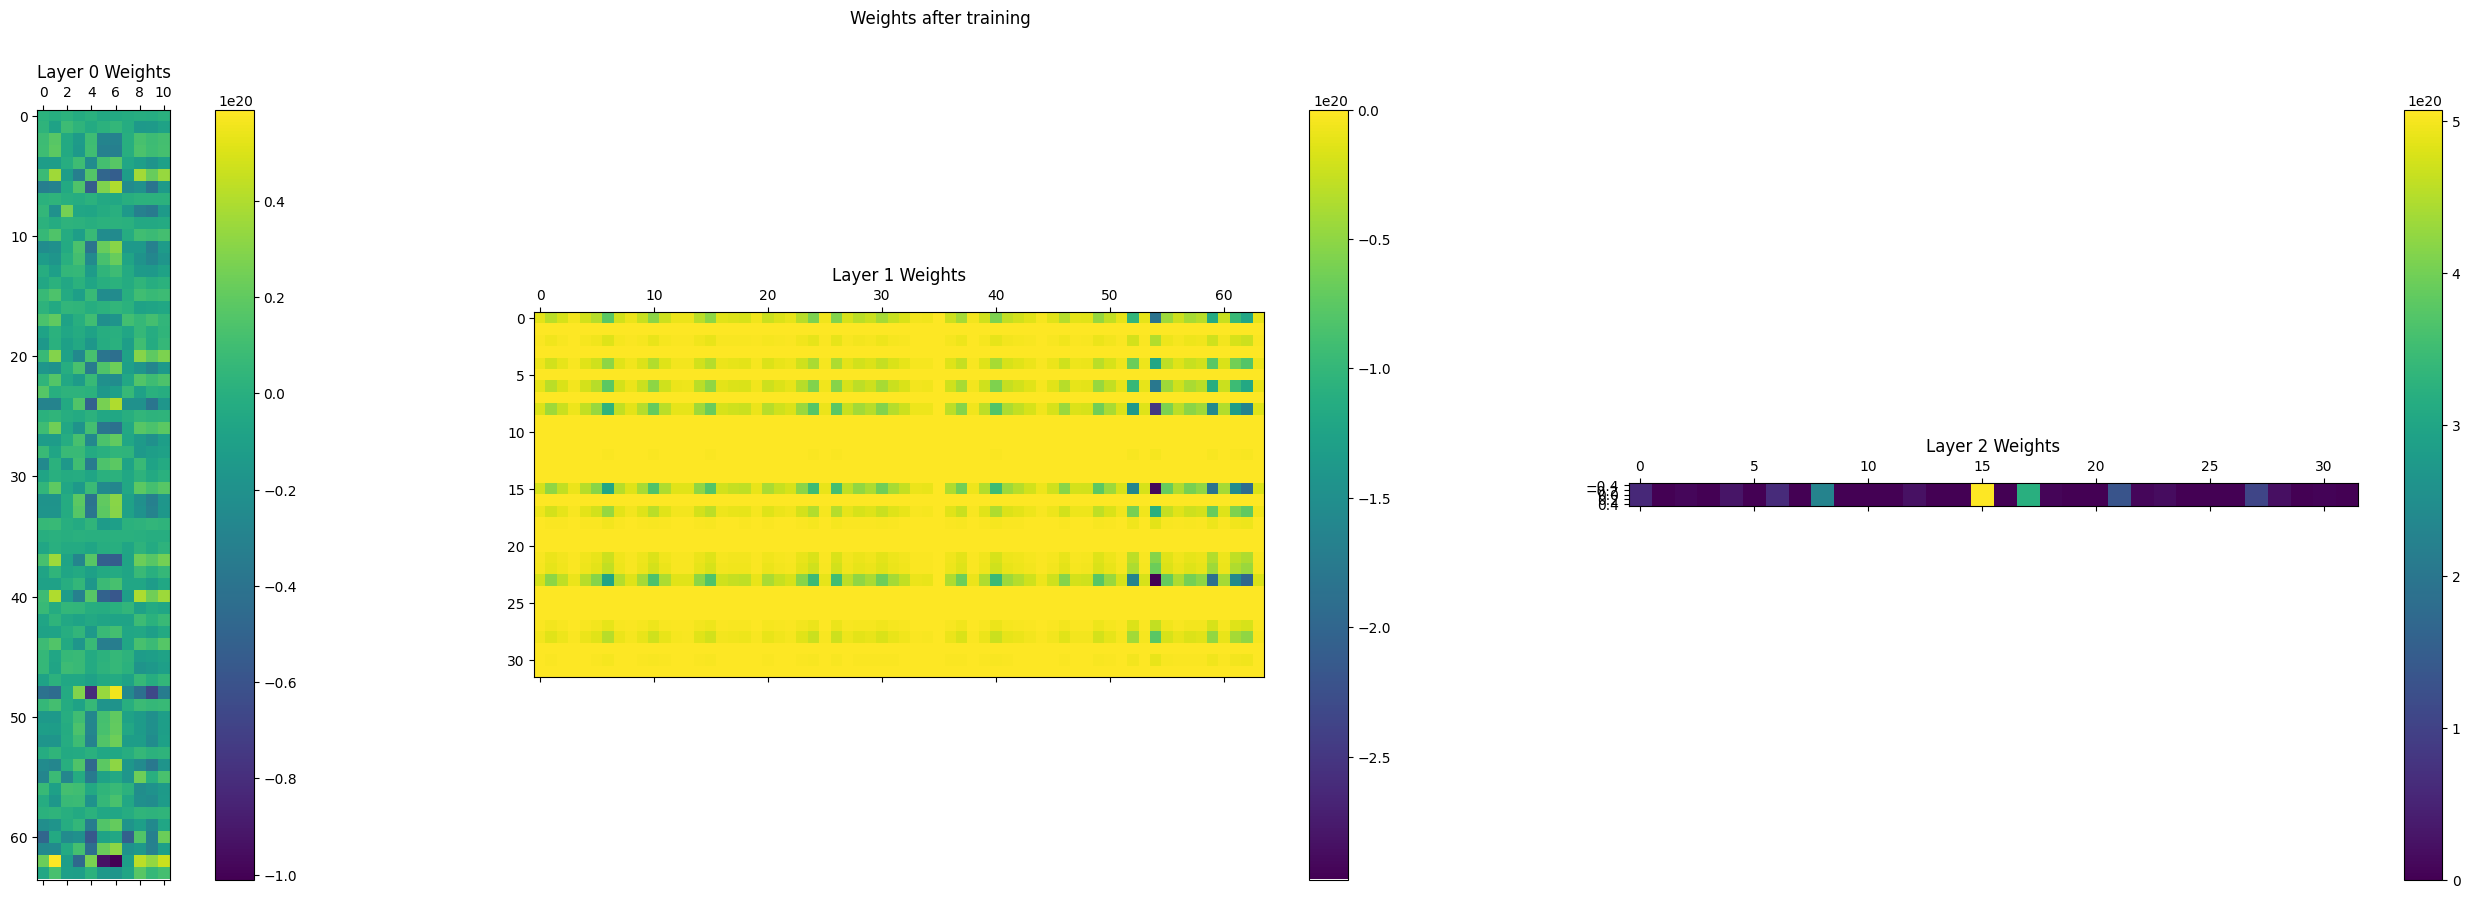

In [47]:
layer_sizes = [wine_X_train.shape[1], 64, 32, 1]
activations = [ReLU(), ReLU(), Linear()]

mlp = MLP(layer_sizes, activations, learning_rate=0.1)

visualize_weights(mlp, title="Weights before training")

metrics = mlp.train(wine_X_train, wine_y_train, epochs=128, batch_size=32, verbose=True)

visualize_weights(mlp, title="Weights after training")

In [48]:
wine_output = mlp.predict(wine_X_test.T) 
wine_output = np.round(wine_output)

print("Accuracy: ", accuracy(wine_y_test, wine_output))
print("MSE: ", mse_loss(wine_y_test, wine_output))

Accuracy:  0.4592307692307692
MSE:  0.7661538461538462
